In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
data_path = "../data/processed/part-00000-cd530e15-795d-43aa-9731-3388b87f5dc7-c000.csv"
df = pd.read_csv(data_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print("Dataset preview:")
display(df.head())

# Check missing values
print("\nMissing values per column:\n", df.isna().sum())

Dataset preview:


,ticker,date,open,high,low,close,volume,post_count,avg_score,total_score,avg_comments,max_score
0,AAPL,2020-09-29,111.697,112.436,110.739,111.243,102615780,0,0.0,0,0.0,0
1,AAPL,2020-09-30,110.958,114.345,110.788,112.918,146318692,0,0.0,0,0.0,0
2,AAPL,2020-10-01,114.704,114.782,112.937,113.885,119085817,0,0.0,0,0.0,0
3,AAPL,2020-10-02,110.089,112.486,109.429,110.219,148407508,0,0.0,0,0.0,0
4,AAPL,2020-10-05,111.078,113.746,110.720,113.597,108956998,0,0.0,0,0.0,0



Missing values per column:
 ticker          0
date            0
open            0
high            0
low             0
close           0
volume          0
post_count      0
avg_score       0
total_score     0
avg_comments    0
max_score       0
dtype: int64


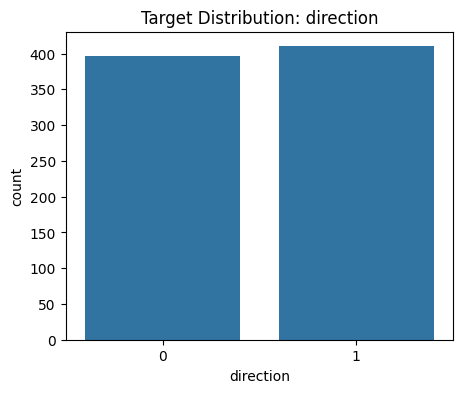

In [3]:
df['close_next'] = df.groupby('ticker')['close'].shift(-1)
df['direction'] = (df['close_next'] > df['close']).astype(int)
df.dropna(inplace=True)

# Daily returns
df['return'] = (df['close'] - df['open']) / df['open']

# Lag features
df['prev_close'] = df.groupby('ticker')['close'].shift(1)
df['prev_return'] = df.groupby('ticker')['return'].shift(1)
df['prev_post_count'] = df.groupby('ticker')['post_count'].shift(1)
df['prev_avg_score'] = df.groupby('ticker')['avg_score'].shift(1)

# Rolling averages (3-day)
df['rolling_avg_close'] = df.groupby('ticker')['close'].rolling(3).mean().reset_index(0, drop=True)
df['rolling_avg_post'] = df.groupby('ticker')['post_count'].rolling(3).mean().reset_index(0, drop=True)

# Drop rows with NaN
df = df.dropna().reset_index(drop=True)

# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x='direction', data=df)
plt.title('Target Distribution: direction')
plt.show()

In [4]:
features = [
    'open', 'high', 'low', 'close', 'volume', 
    'post_count', 'avg_score', 'total_score', 
    'avg_comments', 'max_score',
    'prev_close', 'prev_return', 'prev_post_count', 'prev_avg_score',
    'rolling_avg_close', 'rolling_avg_post'
]

X = df[features]
y = df['direction']

# Train/test split (sequential: 70% train, 30% test)
split_idx = int(len(df) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardize for LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

RandomForest Accuracy: 0.46502057613168724
Confusion Matrix:
 [[ 95  16]
 [114  18]]


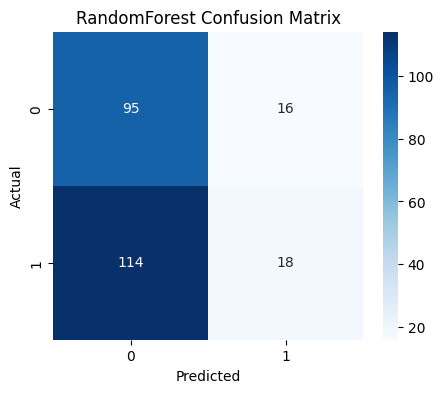

In [5]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RandomForest Confusion Matrix')
plt.show()

LogisticRegression Accuracy: 0.4444444444444444
Confusion Matrix:
 [[ 95  16]
 [119  13]]


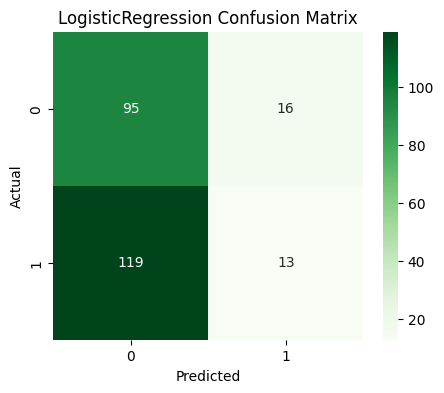

In [6]:
lr_model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("LogisticRegression Accuracy:", accuracy_score(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogisticRegression Confusion Matrix')
plt.show()

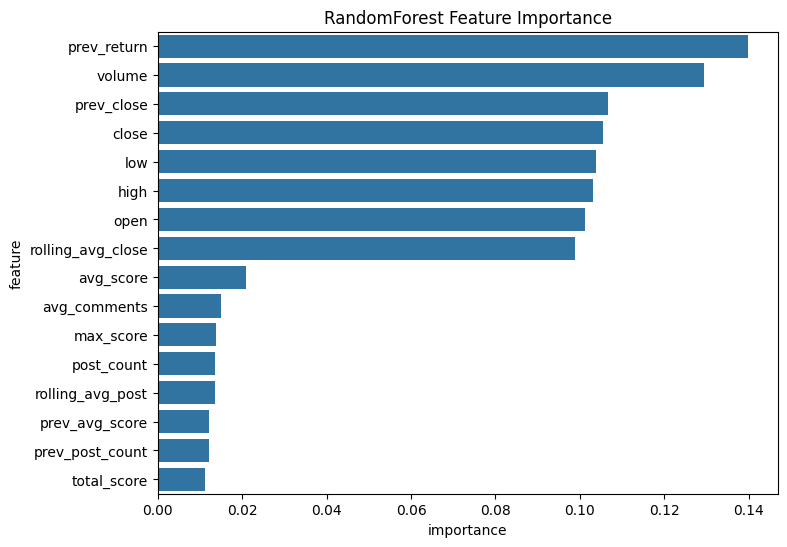

In [7]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('RandomForest Feature Importance')
plt.show()

In [8]:
print(feature_importance_df)

              feature  importance
11        prev_return    0.139925
4              volume    0.129484
10         prev_close    0.106590
3               close    0.105363
2                 low    0.103725
1                high    0.103024
0                open    0.101273
14  rolling_avg_close    0.098810
6           avg_score    0.020769
8        avg_comments    0.014846
9           max_score    0.013702
5          post_count    0.013590
15   rolling_avg_post    0.013464
13     prev_avg_score    0.012176
12    prev_post_count    0.012021
7         total_score    0.011237
